In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from skimage import measure
from skimage import filters

%matplotlib inline

In [2]:
# full path to green channel tif
g_tiffile = 'Channel 488.tif'

I = plt.imread(g_tiffile)

print(type(I))

<class 'numpy.ndarray'>


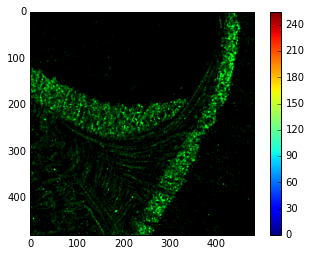

In [3]:
imgplot = plt.imshow(I)
cb = plt.colorbar()

In [4]:
print(I[0,0,:])

# order of indices: rows first, then columns
print(I[210,205,:])

[0 0 0]
[ 0 81  8]


In [5]:
# image dimensions
I.shape

(480, 480, 3)

In [6]:
print('Minimum intensity = ' + str(I.min()))
print('Maximum intensity = ' + str(I.max()))

Minimum intensity = 0
Maximum intensity = 255


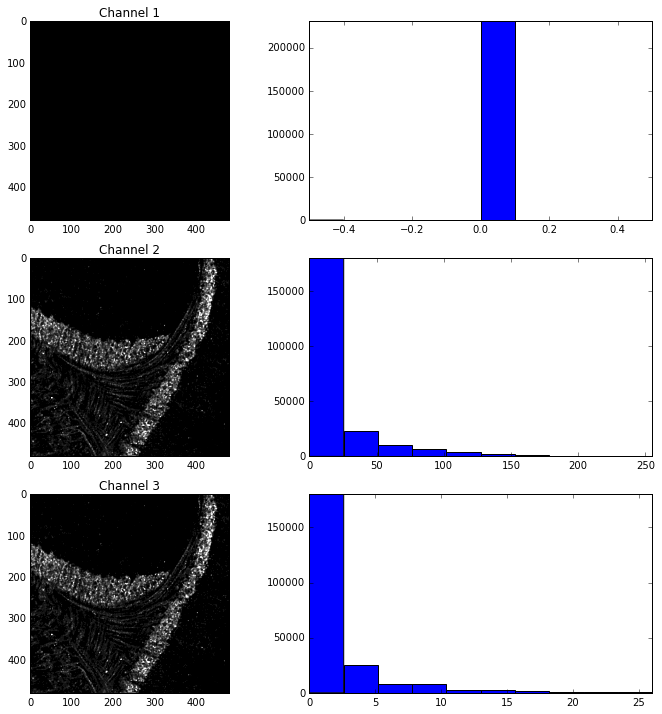

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

# iterate over rows of subplot
for i,ax in enumerate(axes):
    ax[0].imshow(I[:,:,i], cmap='gray')
    ax[0].set_title('Channel '+str(i+1))
    
    ax[1].hist(I[:,:,i].ravel())
    ax[1].axis('tight')
    
fig.tight_layout()

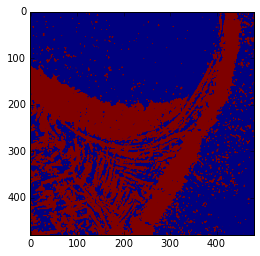

In [8]:
# Extract green channel
Ig = I[:,:,1]

# create mask
mask = 1*(Ig>0) # mask consists of 0's and 1's only
maskplt = plt.imshow(mask)

# Remove surrounding speckles

## Option 1: median filter

/Users/bilgelm/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:106: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  "%s to positive image of type %s." % (dtypeobj_in, dtypeobj))
/Users/bilgelm/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:136: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  warn(msg)


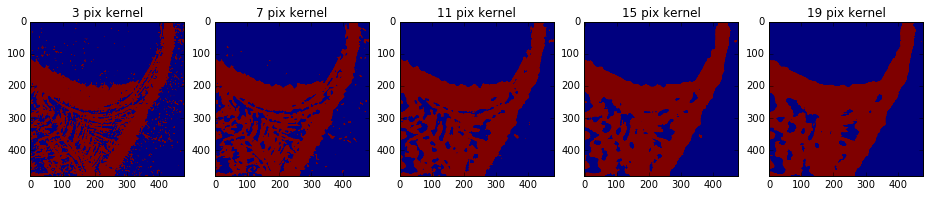

In [9]:
# Option 1: median filter
filt_sizes = list(range(3,20,4))
fig, axes = plt.subplots(nrows=1, ncols=len(filt_sizes), figsize=(16,16))
for i, filt_size in enumerate(filt_sizes):
    kernel = np.ones((filt_size,filt_size))
    mask_medianfiltered = filters.median(mask,kernel)
    axes[i].imshow(mask_medianfiltered)
    axes[i].set_title(str(filt_size)+' pix kernel')

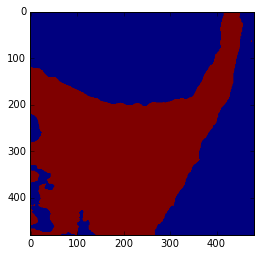

In [10]:
# 19x19 pix kernel works best. Now we need to fill in holes in the mask
mask_medianfiltered_fillhole = sp.ndimage.morphology.binary_fill_holes(mask_medianfiltered)
plt.imshow(mask_medianfiltered_fillhole)

That wasn't exactly the result we wanted. To be able to fill the holes bordering the left and bottom edges, we can first pad these sides of the image with 1's, and then run `binary_fill_holes`.

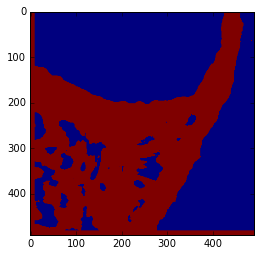

In [11]:
padded_mask = np.pad(mask_medianfiltered, ((0,10),(10,0)), 'constant', constant_values=1)
plt.imshow(padded_mask)

(480, 480)


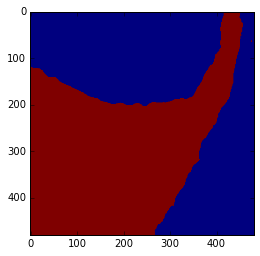

In [12]:
mask_medianfiltered_fillhole = sp.ndimage.morphology.binary_fill_holes(padded_mask)[0:-10,10:]
print(mask_medianfiltered_fillhole.shape) # Sanity check to make sure unpadding is done correctly
plt.imshow(mask_medianfiltered_fillhole)

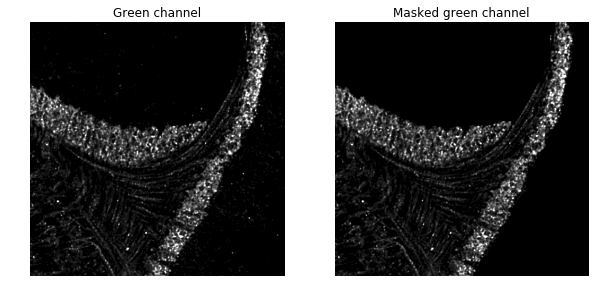

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(Ig, cmap='gray')
plt.axis('off')
plt.title('Green channel')

plt.subplot(122)
plt.imshow(Ig * mask_medianfiltered_fillhole, cmap='gray')
plt.axis('off')
plt.title('Masked green channel')

## Option 2: morphological operations

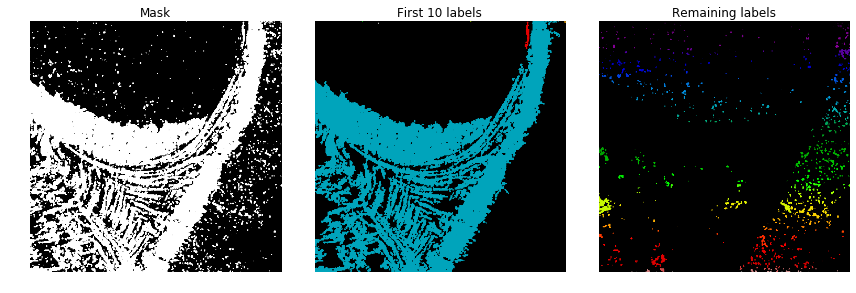

In [14]:
# Option 2: morphological operations
labels = measure.label(mask, background=0)

plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('Mask')

plt.subplot(132)
plt.imshow(labels * (labels<10), cmap='spectral')
plt.axis('off')
plt.title('First 10 labels')

plt.subplot(133)
plt.imshow(labels * (labels>=10), cmap='spectral')
plt.axis('off')
plt.title('Remaining labels')

plt.tight_layout()

In [15]:
# Get the largest non-zero label
largestLabelStats = sp.stats.mode(labels[mask>0])
print('There are '+str(largestLabelStats.count[0])+' pixels with label '+str(largestLabelStats.mode[0]))

There are 84420 pixels with label 3


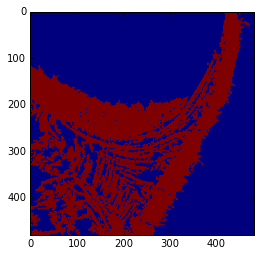

In [16]:
# Compute mask corresponding to largest label
largestLabel = labels==largestLabelStats.mode[0]

plt.imshow(largestLabel)

(480, 480)


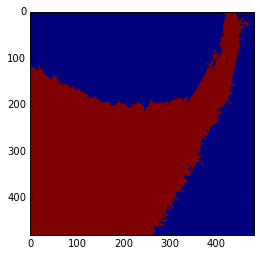

In [17]:
padded_mask = np.pad(largestLabel, ((0,10),(10,0)), 'constant', constant_values=1)
mask_conncomp_fillhole = sp.ndimage.morphology.binary_fill_holes(padded_mask)[0:-10,10:]
print(mask_conncomp_fillhole.shape) # Sanity check to make sure unpadding is done correctly
plt.imshow(mask_conncomp_fillhole)

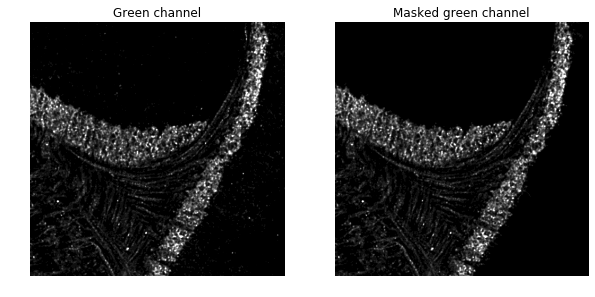

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(Ig, cmap='gray')
plt.axis('off')
plt.title('Green channel')

plt.subplot(122)
plt.imshow(Ig * mask_conncomp_fillhole, cmap='gray')
plt.axis('off')
plt.title('Masked green channel')